In [33]:
#import mlflow
import mlflow
import mlflow.sklearn

import joblib
from joblib import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#For modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

In [34]:
pricing = pd.read_csv("https://getaround-deployment.s3.eu-west-3.amazonaws.com/get_around_pricing_project.csv")

In [35]:
pricing.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [36]:
#drop first column of DataFrame
pricing.drop("Unnamed: 0", axis=1,inplace=True)

In [37]:
pricing.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


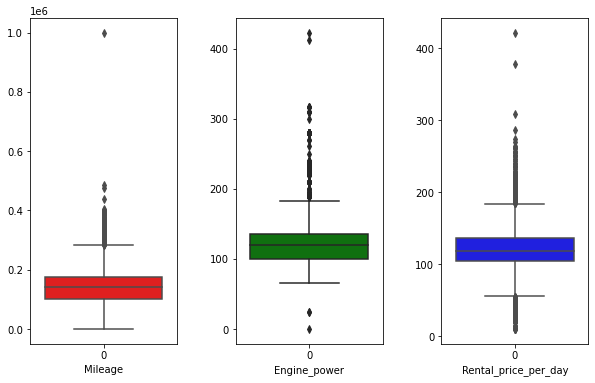

In [38]:
# Boxplot for each columns
fig, ax = plt.subplots(1,3, figsize=(10, 6))
plt.subplots_adjust(wspace=0.4)
#For the mileage
sns.boxplot(data=pricing['mileage'], ax=ax[0], color='red',)
ax[0].set_xlabel('Mileage')
#For the engine_power
sns.boxplot(data=pricing['engine_power'], ax=ax[1], color='g')
ax[1].set_xlabel('Engine_power')
#For the rental_price_per_day
sns.boxplot(data=pricing['rental_price_per_day'], ax=ax[2], color='blue')
ax[2].set_xlabel('Rental_price_per_day')
plt.show()

In [39]:
pricing.shape

(4843, 14)

In [40]:
pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

In [41]:
#Percentage of missing values
display(100*pricing.isnull().sum()/pricing.shape[0])

model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

In [42]:
# Basics stats
pricing.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
model_key,4843,28,Citroën,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,4843.0,NaN,NaN,NaN,140962.799504,60196.740703,-64.0,102913.5,141080.0,175195.5,1000376.0
engine_power,4843.0,NaN,NaN,NaN,128.98823,38.99336,0.0,100.0,120.0,135.0,423.0
fuel,4843,4,diesel,4641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paint_color,4843,10,black,1633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_type,4843,8,estate,1606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
private_parking_available,4843,2,True,2662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gps,4843,2,True,3839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_air_conditioning,4843,2,False,3865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
automatic_car,4843,2,False,3881,NaN,NaN,NaN,NaN,NaN,NaN,NaN


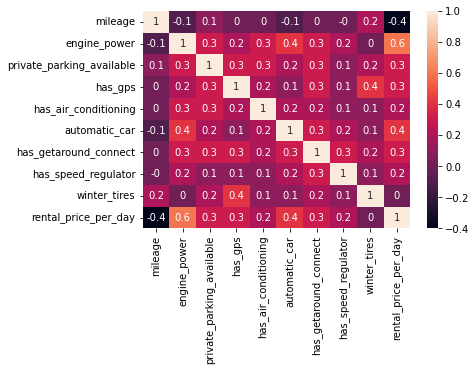

In [43]:
#Correlation
matrix_cor = pricing.corr().round(1)
sns.heatmap(data=matrix_cor, annot=True);

In [44]:
pricing.columns

Index(['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color',
       'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day'],
      dtype='object')

## Modeling

In [45]:
# Separate target variable y from features X
target_name = "rental_price_per_day"
y = pricing.loc[:,target_name]
X = pricing.drop(target_name,axis=1)

In [46]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['mileage', 'engine_power']
Found categorical features  ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


In [47]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [48]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[('imputer',SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(drop='first',handle_unknown = 'ignore', sparse=False)) # first column will be dropped to avoid creating correlations between features
    ])

In [49]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [50]:
# Dividing into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [51]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) 


Performing preprocessings on train set...
Performing preprocessings on test set...


/Users/rodelin/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [52]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [53]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[132.11454579 118.97972881 118.29220712 ... 120.52794433 101.98350878
 118.31958381]



In [54]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")

Predictions on test set...
...Done.


In [55]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(y_test, Y_test_pred))

R2 score on training set :  0.7156703443405992
R2 score on test set :  0.6892815152580107


In [57]:
joblib.dump(regressor,"model_reg.joblib")
joblib.dump(preprocessor,"preprocessor.joblib")

['preprocessor.joblib']